<a href="https://colab.research.google.com/github/YaninaK/cv-segmentation/blob/b1/notebooks/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corrosion detection in steel pipes

## 1. EDA

* **The objective**:
The objective of this challenge is to train a model that have the highest possible score for the segmentation of groove defects using the provided data

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1 https://github.com/YaninaK/cv-segmentation.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/X_train_corrected.zip -d /content/cv-segmentation/data/raw
  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/masks.zip -d /content/cv-segmentation/data/raw
  !cp /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/y_train.csv -d /content/cv-segmentation/data/raw

%cd /content/cv-segmentation/notebooks

/content/cv-segmentation/notebooks


## Install Packages

In [2]:
#install packages
!pip install imutils
!pip install torchsummary

* Для воспроизводимости среды необходимые версии библиотек лучше зафиксировать, например, в файле requirements.txt
```
imutils==0.5.4
torchsummary==1.5.1
...
```


Тогда установка будет выглдеть так:

```
!pip install -r requirements.txt
```

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import imutils.paths as paths
import glob
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
from torch.optim import Adam
from torchsummary import summary
from tqdm import tqdm
import random
import shutil
import cv2
from scipy.ndimage import binary_fill_holes
import pandas as pd
from pathlib import Path

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

* Импорт лучше упорядочить по алфавиту с разделением на секции и по типам, например, как это делает библиотека [isort](https://pycqa.github.io/isort/).
Это позволит избежать повторений как, например ```from tqdm import tqdm```, ```import random``` и т.п.

Тогда иморт выглядел бы так:


```
import glob
import os
import random
import shutil
from pathlib import Path

import cv2
import imutils.paths as paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from scipy.ndimage import binary_fill_holes
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from tqdm import tqdm
```

## Look at the data


* Блок Look at the data (EDA) лучше делать в отдельном ноутбуке и давать на него ссылку

In [5]:
# Read file
y_train=pd.read_csv('../data/raw/y_train.csv',index_col=0) #Table with index being the name of the patch
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9674 entries, well_10_patch_0 to well_15_patch_99
Columns: 1296 entries, 0 to 1295
dtypes: int64(1296)
memory usage: 95.7+ MB


In [6]:
display(y_train.head())

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* ```display``` - избыточный код. Здесь достаточно ```y_train.head()```:

In [7]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
dict_wells_masks = {}


for name_patch in y_train.index:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_masks.keys()):
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))] += 1

    else:
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_masks.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_masks[key])

print('Total number of wells :',len(dict_wells_masks.keys()))
print('Total number of patches :', sum(dict_wells_masks.values()))

# First well and 450 first images of well 1 are false

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


In [9]:
folder_path = '../data/raw/images'
file_names = os.listdir(folder_path)

dict_wells_images = {}


for name_patch in file_names:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_images.keys()):
        dict_wells_images[int(name_patch[5:7].replace('_', ''))] += 1

    else:
        dict_wells_images[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_images.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_images[key])

print('Total number of wells :',len(dict_wells_images.keys()))
print('Total number of patches :', sum(dict_wells_images.values()))

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


* Здесь лучше использовать Counter.
* Использовать трижды код ```int(name_patch[5:7].replace('_', ''))``` неэффективно.
* Для вывода результата лучше использовать f-strings:
```
f'Well : {key} Number of patches : {dict_wells_masks[key]}'
```
* Totals для наглядности имеет смысл отделить строкой с помощью ```\n```:
```
f'\nTotal number of wells : {len(dict_wells_masks)}'
```

Поскольку код используется неоднократно, лучше его оформить в виде формулы:

In [10]:
from collections import Counter

def get_patches_per_well(patches_list):
  patch_names = [int(name_patch.split("_")[1]) for name_patch in patches_list]
  dict_wells_patches = Counter(patch_names)

  for key in sorted(dict_wells_patches.keys()):
    print(f'Well : {key} Number of patches : {dict_wells_patches[key]}')

  print(f'\nTotal number of wells : {len(dict_wells_patches)}')
  print(f'Total number of patches :', sum(dict_wells_patches.values()))

  return dict_wells_patches

In [11]:
dict_wells_masks = get_patches_per_well(y_train.index)

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203

Total number of wells : 15
Total number of patches : 9674


In [12]:
folder_path = '../data/raw/images'
file_names = os.listdir(folder_path)
dict_wells_images = get_patches_per_well(file_names)

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203

Total number of wells : 15
Total number of patches : 9674


In [13]:
y_keys = dict(sorted(dict_wells_masks.items())).keys()
image_keys = dict(sorted(dict_wells_images.items())).keys()

for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')

Mask well : 1 Number of patches : 166
Image well : 1 Number of patches : 166 

Mask well : 2 Number of patches : 616
Image well : 2 Number of patches : 616 

Mask well : 3 Number of patches : 1774
Image well : 3 Number of patches : 1774 

Mask well : 4 Number of patches : 59
Image well : 4 Number of patches : 59 

Mask well : 5 Number of patches : 98
Image well : 5 Number of patches : 98 

Mask well : 6 Number of patches : 964
Image well : 6 Number of patches : 964 

Mask well : 7 Number of patches : 1654
Image well : 7 Number of patches : 1654 

Mask well : 8 Number of patches : 78
Image well : 8 Number of patches : 78 

Mask well : 9 Number of patches : 166
Image well : 9 Number of patches : 166 

Mask well : 10 Number of patches : 80
Image well : 10 Number of patches : 80 

Mask well : 11 Number of patches : 1512
Image well : 11 Number of patches : 1512 

Mask well : 12 Number of patches : 44
Image well : 12 Number of patches : 44 

Mask well : 13 Number of patches : 1905
Image well

Для того чтобы убедиться, что число patches у Mask well и Image well совпадают, лучше использовать ```assert```:

In [14]:
for y_key in sorted(dict_wells_masks.keys()):
  assert dict_wells_masks[y_key] == dict_wells_images[y_key]

* ```dict(sorted(dict_wells_masks.items())).keys()``` - неудачная конструкция;
достаточно ```dict_wells_masks.keys()```
* Использование
```
if i == 15:
    break
```
избыточно - у нас всего 15 скважин, цикл остановится и без break.
Соответственно, избыточно использовать ```enumerate```.

### Imbalance analysis

In [15]:
n_patches = 0
n_pixels = 0
overall = 0
for row in y_train.iterrows():

    psum = np.sum(row[1])
    if psum > 0:
        n_patches += 1
        n_pixels += psum
    overall += len(row[1])

In [16]:
print('Number of patches with corrosion :', n_patches)
print('Number of pixels with corrosion :', n_pixels)
print('Overall number of pixels :', overall)
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')

Number of patches with corrosion : 7674
Number of pixels with corrosion : 896993
Overall number of pixels : 12537504
Ratio of pixels with corrosion : 7.154 %
Ratio of patches with corrosion : 79.326 %


* Эффективнее было бы посчитать так:

In [17]:
n_patches = (y_train.sum(axis=1) > 0).sum()
n_pixels = y_train.sum(axis=1).sum()
overall = y_train.shape[0] * y_train.shape[1]

* Код последних двух строк избыточен. Лучше сделать так:

In [18]:
print(f'Ratio of pixels with corrosion : {n_pixels*100/overall: .3f} %')
print(f'Ratio of patches with corrosion : {n_patches*100/len(y_train): .3f} %')

Ratio of pixels with corrosion :  7.154 %
Ratio of patches with corrosion :  79.326 %


* Имеет смысл сделать ```Imbalance analysis``` в разрезе скважин:

In [19]:
well_ref = y_train.reset_index()["index"].apply(lambda x: int(x.split("_")[1])).tolist()

masks_frame = y_train.copy()
masks_frame["n_patches"] = y_train.sum(axis=1) > 0
masks_frame["n_pixels"] = masks_frame.sum(axis=1)
masks_frame["well"] = well_ref

n_patches = masks_frame.groupby("well")['n_patches'].sum()
n_pixels = masks_frame.groupby("well")['n_pixels'].sum()
overall = masks_frame.groupby("well").agg(overall = ("well", "count")) * y_train.shape[1]
count = masks_frame["well"].value_counts()
well_info = pd.concat([n_patches, n_pixels, overall, count], axis=1)

well_info["pixels with corrosion"] = well_info["n_pixels"] / well_info["overall"]
well_info["patches with corrosion"] = well_info["n_patches"] / well_info["count"]

well_info

,n_patches,n_pixels,overall,count,pixels with corrosion,patches with corrosion
well,,,,,,
1,130,11116,215136,166,0.05167,0.783133
2,580,50541,798336,616,0.063308,0.941558
3,1611,234831,2299104,1774,0.10214,0.908117
4,53,5139,76464,59,0.067208,0.898305
5,24,1968,127008,98,0.015495,0.244898
6,496,70235,1249344,964,0.056218,0.514523
7,1420,105092,2143584,1654,0.049026,0.858525
8,30,1678,101088,78,0.016599,0.384615
9,0,0,215136,166,0.0,0.000000


* Данные в разрезе скважин существенно отличаются по доле пикселей с коррозией. Это необходимо учитывать при составлении обучающей и валидационной/ тестовой выборок. По 9 и 10 скважинам данных по коррозии нет.

### Preprocessing analysis

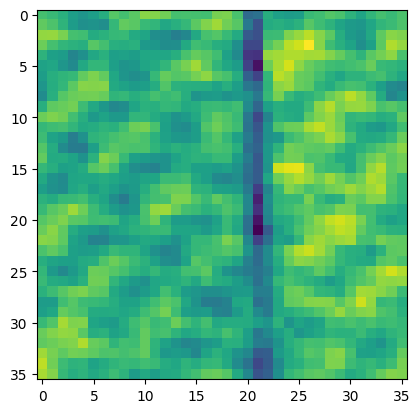

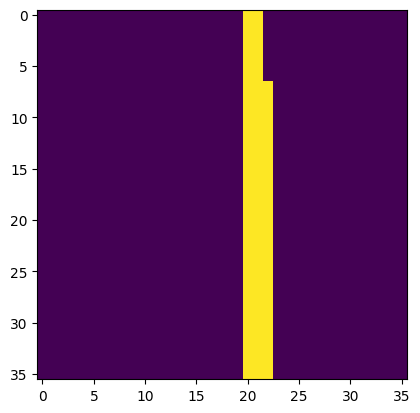

In [20]:
image = np.load('../data/raw/images/well_2_patch_3.npy')
plt.imshow(image)
plt.show()

mask = np.array(y_train.loc['well_2_patch_3']).reshape(36,36)
plt.imshow(mask)
plt.show()

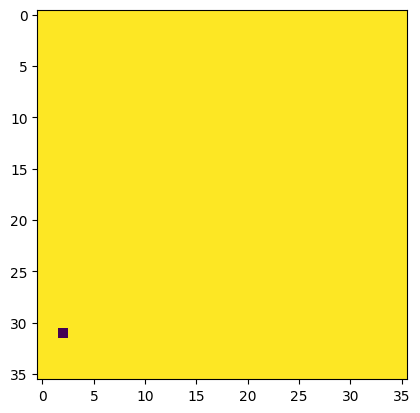

In [21]:
# Data analysis
file_names = os.listdir('../data/raw/images/')
images = []
for img_name in file_names:
    img = np.load(os.path.join('../data/raw/images/', img_name))

    if np.sum(img < -800) > 0:
        plt.imshow(img)
        plt.show()
        break

    images.append(img)

In [22]:
np.min(img), np.max(img), np.unique(img),

(-999.0,
 0.25783953,
 array([-9.99000000e+02, -1.20594054e-01, -1.20438039e-01, ...,
         4.09692228e-02,  1.22388780e-01,  2.57839531e-01], dtype=float32))

In [23]:
 # Data analysis
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
print('Number patches train set:', len(images_train))
print('Number of outliers:', count_outliers*100/len(file_names))

100%|██████████| 9674/9674 [00:05<00:00, 1717.31it/s]


Number patches train set: 9674
Number of outliers: 3.514575149886293


* В Number of outliers речь о доле выбросов в процентах, а не о числе выбросов

In [24]:
# Statistics on the train images

cleaned_img = np.nan_to_num(flat_list_img_train)
print('For the training images :')
print('Mean :',np.mean(cleaned_img))
print('Std :',np.std(cleaned_img))
print('Max :',np.max(cleaned_img))
print('Min :',np.min(cleaned_img))

For the training images :
Mean : -4.6509714
Std : 68.01103
Max : 0.4703434
Min : -999.25


100%|██████████| 9674/9674 [00:04<00:00, 2268.53it/s]


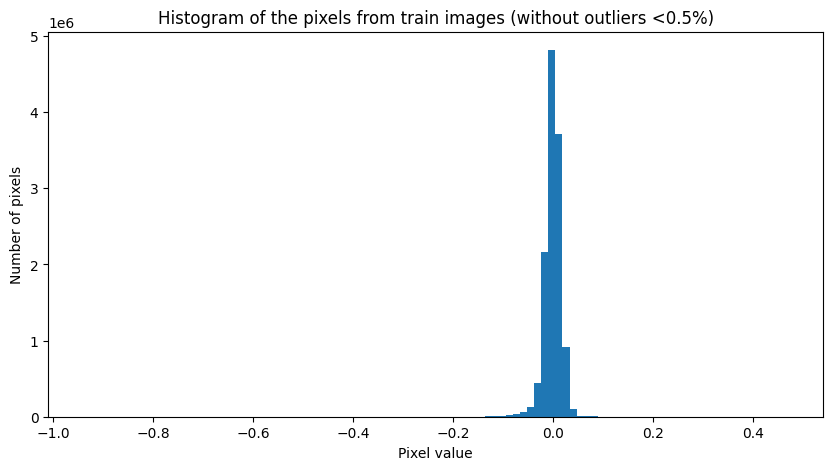

Ratio outliers pixels: 0.465 %


In [25]:
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
cleaned_img = np.nan_to_num(flat_list_img_train)
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')

* здесь лучше убрать дублирование кода:
```
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
cleaned_img = np.nan_to_num(flat_list_img_train)
```
и оставить только
```
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')
```
* Анализировать информацию по всем точкам ```flat_list_img_train``` не информативно. Лучше анализировать по кадрам и в разрезе скважин:

* Пропуски

In [26]:
image_arr = np.reshape(np.asarray(images_train), (len(images_train), -1))
image_frame = pd.DataFrame(image_arr, y_train.index)

image_frame.describe().T['count'].value_counts()

,count
count,
9673.0,674
9674.0,612
9672.0,10


In [27]:
image_frame_nan = image_frame.isna().sum(axis=1).reset_index()
image_frame_nan["well"] = well_ref
image_frame_nan.groupby("well")[0].sum()

,0
well,
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


* Почти все пропуски выпали на 13 скважину.

In [28]:
image_frame_nan[(image_frame_nan["well"] == 13) & (image_frame_nan[0] >0)]

,index,0,well
7281,well_13_patch_1060,683,13


In [29]:
image_frame_nan[(image_frame_nan["well"] == 11) & (image_frame_nan[0] > 0)]

,index,0,well
1266,well_11_patch_705,11,11


* Снимок ```well_13_patch_1060``` лучше удалить из выборки, в снимке ```well_11_patch_705``` можно заполнить пропуски.

* Выбросы

In [30]:
image_frame["well"] = well_ref

a_min = image_frame.iloc[:, :-1].min(axis=1)
a_max = image_frame.iloc[:, :-1].max(axis=1)

(a_min < -0.25).sum(), (a_max > 0.4).sum()

(347, 9)

In [31]:
image_frame_anomaly = (image_frame.iloc[:, :-1] < -0.25).sum(axis=1).reset_index()
image_frame_anomaly["well"] = well_ref
image_frame_anomaly.set_index("index")[a_min < -0.25].groupby("well").count()

,0
well,
1,8
2,23
3,62
5,5
6,45
7,60
8,1
9,3
10,3


* Число изображений с выбросами в разрезе скважин в пределах 60 - их можно удалить.

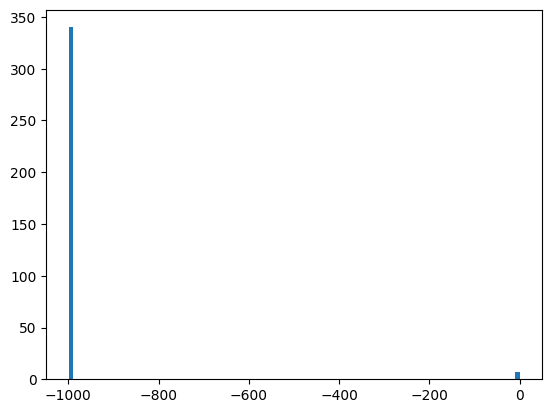

In [32]:
plt.hist(a_min[(a_min < -0.25)] , bins=100);

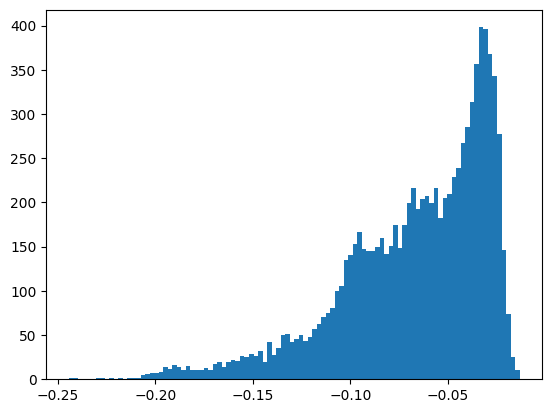

In [33]:
plt.hist(a_min[(a_min > -0.25)] , bins=100);

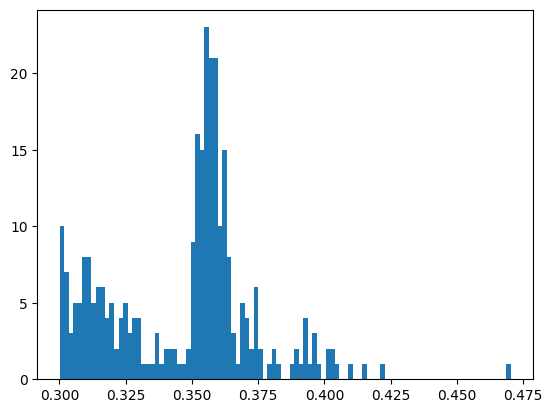

In [34]:
plt.hist(a_max[a_max > 0.3] , bins=100);

* 347 кадров с минимальным значением меньше -0.25 - выбросы. Их лучше убрать из обучающей выборки:

In [35]:
images_train_array = image_frame[a_min > -0.25]

images_train_array.shape, len(images_train)

((9327, 1297), 9674)

* Формула для удаления выбросов:

In [36]:
def clean_outliers(csv_file: str, root_dir: str):
    y_train = pd.read_csv(csv_file, index_col=0)

    file_names = os.listdir(root_dir)
    images_train = []
    for img_name in tqdm(file_names):
      img = np.load(os.path.join(root_dir, img_name))
      images_train.append(img)

    image_arr = np.reshape(np.asarray(images_train), (len(images_train), -1))
    image_arr_min = np.nan_to_num(image_arr).min(axis=1)

    y_train = y_train.iloc[image_arr_min > -0.25].reset_index()

    return y_train, image_arr[image_arr_min > -0.25]

In [37]:
root_dir = '../data/raw/images/'
csv_file = '../data/raw/y_train.csv'

masks_frame, image_arr = clean_outliers(csv_file, root_dir)
masks_frame.shape, image_arr.shape

100%|██████████| 9674/9674 [00:01<00:00, 8610.50it/s]


((9327, 1297), (9327, 1296))

 ## Распределение скважин между обучающей, валидационной и тестовой выборкой

In [38]:
masks_frame["well"] = masks_frame["index"].apply(lambda x: int(x.split("_")[1]))
well_mask_frame = masks_frame.iloc[:, 1:].groupby("well").mean()

In [39]:
well_mask_frame

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.063291,0.012658,0.006329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.193929,0.026981,0.006745,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.003505,0.012266,0.022780,0.047313,0.069509,0.074766,0.071262,0.055491,...,0.150117,0.055491,0.025701,0.004673,0.002336,0.002921,0.003505,0.003505,0.002336,0.002336
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.064516,0.096774,0.096774,0.096774,0.086022,0.053763,0.043011,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.013058,0.032644,0.044614,0.054407,0.059848,0.053319,0.056583,0.053319,0.053319,0.051143,...,0.087051,0.083787,0.068553,0.056583,0.044614,0.031556,0.030468,0.023939,0.022851,0.019587
7,0.015056,0.020703,0.031368,0.027604,0.022585,0.021330,0.024467,0.034504,0.031368,0.024467,...,0.047679,0.164366,0.269134,0.289210,0.157465,0.055207,0.026976,0.028231,0.025094,0.020703
8,0.025974,0.025974,0.025974,0.025974,0.012987,0.025974,0.012987,0.025974,0.000000,0.025974,...,0.012987,0.025974,0.012987,0.025974,0.012987,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
well_info = masks_frame.iloc[:, 1:].groupby("well").agg(patches_count = ("0", "count"))
well_info["mean_corrosion"] = well_mask_frame.mean(axis=1).sort_index()

well_info

,patches_count,mean_corrosion
well,,
1,158,0.051019
2,593,0.062549
3,1712,0.101449
4,59,0.066515
5,93,0.016129
6,919,0.055989
7,1594,0.048356
8,77,0.016514
9,163,0.000000


In [41]:
well_info.describe()

,patches_count,mean_corrosion
count,15.000000,15.000000
mean,621.800000,0.053339
std,687.652549,0.032527
min,44.000000,0.000000
25%,85.000000,0.032435
50%,196.000000,0.055989
75%,1186.500000,0.071963
max,1845.000000,0.101725


In [42]:
image_frame = pd.DataFrame(image_arr)
image_frame["well"] = masks_frame["well"]
well_image_frame = image_frame.groupby("well").median().sort_index()

### Кластеризация скважин по данным снимков и разметки.

In [43]:
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [44]:
image_clustering = DBSCAN(eps=0.08, min_samples=2).fit(well_image_frame)
well_info.loc[:, "image_cluster"] = image_clustering.labels_

silhouette_score(well_image_frame, image_clustering .fit_predict(well_image_frame))

0.38998383

In [45]:
mask_clustering = DBSCAN(eps=6, min_samples=2).fit(well_mask_frame)
well_info.loc[:, "mask_cluster"] = mask_clustering.labels_

silhouette_score(well_mask_frame, mask_clustering.fit_predict(well_mask_frame))

0.44535062211161774

In [46]:
well_info

,patches_count,mean_corrosion,image_cluster,mask_cluster
well,,,,
1,158,0.051019,0,0
2,593,0.062549,0,0
3,1712,0.101449,0,0
4,59,0.066515,0,0
5,93,0.016129,0,0
6,919,0.055989,0,0
7,1594,0.048356,0,0
8,77,0.016514,0,0
9,163,0.000000,0,0


* 12 скважина отличается от остальных и по снимкам, и по разметке. Поместим ее в обучающую выборку.

### Распределение скважин и оценка распределения

* При распределении скважин между обучающей, валидационной и тестовой выборками, стараемся добиться более-менее сбалансированных характеристик.

In [47]:
train = [6, 7, 8, 9, 11, 12, 13, 14]
val = [3, 10, 15]
test = [1, 2, 4, 5]

In [48]:
n = len(image_frame)
n1 = int(n * 0.7)
n2 = int(n * 0.2)
n3 = n - n1 - n2
print(n1, n2, n3)

n_train = well_info.loc[train, "patches_count"].sum()
n_val = well_info.loc[val, "patches_count"].sum()
n_test = well_info.loc[test, "patches_count"].sum()

print(n_train, n_val, n_test)
print(f"{n_train/n1: .2f} {n_val/n2: .2f} {n_test/n3: .2f}")

6528 1865 934
6439 1985 903
 0.99  1.06  0.97


In [49]:
mean_corrosion_train = well_info.loc[train, "mean_corrosion"].mean()
mean_corrosion_val = well_info.loc[val, "mean_corrosion"].mean()
mean_corrosion_test = well_info.loc[test, "mean_corrosion"].mean()

print(f"{mean_corrosion_train: .3f} {mean_corrosion_val: .3f} {mean_corrosion_test: .3f}")

 0.054  0.058  0.049


## Label Refinement

### binary fill holes

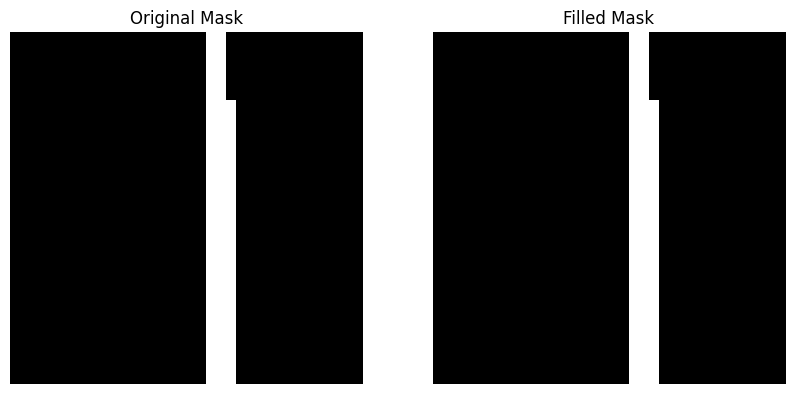

In [50]:
filled = binary_fill_holes(mask)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

# Plot filled mask
axes[1].imshow(filled, cmap='gray')
axes[1].set_title('Filled Mask')
axes[1].axis('off')

plt.show()

### Structuring Element & Morphological Operations

In [51]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation
result = cv2.dilate(mask, adaptive_kernel)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'


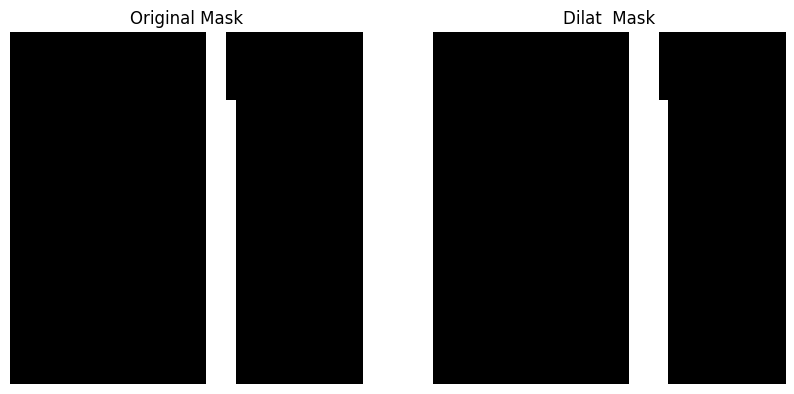

In [52]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation

result = cv2.dilate(np.ones((36, 36)) * mask, adaptive_kernel)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

В выражении
```
result = cv2.dilate(mask, adaptive_kernel)
```
mask должна быть в в виде 0/1, а не False/ True.

Исправленная версия выглядит так:
```
result = cv2.dilate(np.ones((36, 36)) * mask, adaptive_kernel)
```


## Image Enhancement

### CLAHE and bilateral filter

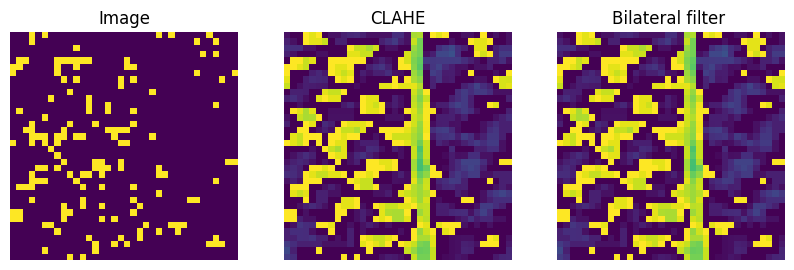

In [53]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image = np.uint8(image * 255)

# Apply CLAHE to the grayscale image
clahe_img = clahe.apply(image)
#Apply bilateral filter
bilateral_img = cv2.bilateralFilter(clahe_img, d=2, sigmaColor=4, sigmaSpace=4)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot Image
image = np.uint8(image /255)

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

#  Plot CLAHE result
axes[1].imshow(clahe_img)
axes[1].set_title('CLAHE')
axes[1].axis('off')

# Plot Bilateral filter
axes[2].imshow(clahe_img/255)
axes[2].set_title('Bilateral filter ')
axes[2].axis('off')
plt.show()

## Рекомендации

1. Блок Look at the data (EDA) лучше делать в отдельном ноутбуке и давать на него ссылку.
2. Для воспроизводимости среды необходимые версии библиотек лучше зафиксировать, например, в файле requirements.txt.
3. Импорт лучше упорядочить по алфавиту с разделением на секции и по типам, например, как это делает библиотека [isort](https://pycqa.github.io/isort/).
Это позволит избежать повторений как, например ```from tqdm import tqdm```, ```import random``` и т.п.
4. Лучше избегать избыточного кода, как, например, в ```display(y_train.head())``` - достаточно ```y_train.head()```.
5. Для генерации ```dict_wells_masks``` и ```dict_wells_images```, чтобы не дублировать код, лучше воспользоваться формулой:

```
from collections import Counter

def get_patches_per_well(patches_list):
  patch_names = [int(name_patch.split("_")[1]) for name_patch in patches_list]
  dict_wells_patches = Counter(patch_names)

  for key in sorted(dict_wells_patches.keys()):
    print(f'Well : {key} Number of patches : {dict_wells_patches[key]}')

  print(f'\nTotal number of wells : {len(dict_wells_patches)}')
  print(f'Total number of patches :', sum(dict_wells_patches.values()))

  return dict_wells_patches
```
6. Для того чтобы убедиться, что число patches у Mask well и Image well совпадают, лучше использовать ```assert```:

```
for y_key in sorted(dict_wells_masks.keys()):
  assert dict_wells_masks[y_key] == dict_wells_images[y_key]

```
7. ```dict(sorted(dict_wells_masks.items())).keys()``` - неудачная конструкция;
достаточно ```dict_wells_masks.keys()```
8. В коде

```
for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')
```

использование
```
if i == 15:
    break
```
избыточно - у нас всего 15 скважин, цикл остановится и без break.
Соответственно, избыточно использовать и ```enumerate```.

9. Код строк ниже избыточен:
```
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')
```
Лучше написать так:
```
print(f'Ratio of pixels with corrosion : {n_pixels*100/overall: .3f} %')
print(f'Ratio of patches with corrosion : {n_patches*100/len(y_train): .3f} %')
```
Эти параметры лучше проанализировать в разрезе скважин - ```Ratio of pixels with corrosion``` существенно отличается межуду скважинами - у скважин 9 и 10 информации разметки по коррозиии нет.

10. В ячейке Data analysis в Number of outliers речь о доле выбросов в процентах, а не о числе выбросов - лучше написать Ratio of outliers.

11. В ячейке, где генерируется Histogram of the pixels from train images имеет смысл убрать дублирование кода.

12. Пропуски есть только в 2 изображениях. Почти все пропуски приходятся на ```well_13_patch_1060 ```, его лучше удалить.

13. Анализировать информацию по всем точкам ```flat_list_img_train``` не информативно. Лучше смотеть по кадрам и в разрезе скважин: 347 кадров с минимальным значением меньше -0.25 - выбросы - в пределах 60 кадров на одну скважину. Их имеет смысл убрать из обучающей выборки.

14. Чтобы избежать data leakage, распределение данных между обучающей, валидационной и тестовой выборкой делаем по скважинам:
```
train = [6, 7, 8, 9, 11, 12, 13, 14]
val = [3, 10, 15]
test = [1, 2, 4, 5]
```
При распределении скважин стараемся добиться более-менее сбалансированных характеристик.

15. Материалы о Label Refinement и Image Enhancement лучше поместить в EDA.

16. Для удобства чтения хорошо использовать подзаголовки, чтобы была видна структура материла. Этого легко добиться, используя разное число знаков ```#```, например: ```#```, ```##``` или ```###```, в зависимости от уровня подзаголовка.


Рекомендации реализованы в коде этого ноутбука, код можно посмотреть выше.
